## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from random import sample
from IPython.display import clear_output
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import matplotlib.gridspec as gridspec


### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks_basic/lab02_deep_learning/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text)
text = text.lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [4]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2023-12-14 18:12:20--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 262521 (256K) [text/plain]
Сохранение в: «onegin.txt.3»

onegin.txt.3        100%[===================>] 256,37K  --.-KB/s    за 0,06s   

2023-12-14 18:12:20 (4,00 MB/s) - «onegin.txt.3» сохранён [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [5]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
text = ''.join(text)
text = text.lower()

#assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [6]:
tokens = sorted(set(text))
assert '<' not in tokens and '_' not in tokens and '>' not in tokens
tokens.append('<') # start
tokens.append('>') # end
tokens.append('_') # pad

num_tokens = len(tokens)

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [7]:
# dict <index>:<char>
# Your great code here

# dict <char>:<index>
# Your great code here
token_to_idx = {}
idx_to_token = {}
for idx, token in enumerate(tokens):
    token_to_idx[token] = idx
    idx_to_token[idx] = token

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

In [8]:
parts = []
for i, part in enumerate(text.split('\n\n')):
    if len(part) > 25:
        parts.append(part)

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [9]:
# Your code here
def get_batches(dataset, batch_size=64):
    n = len(dataset)
    
    indices = np.arange(n)
    np.random.shuffle(indices)
    
    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        
        batch_idx = indices[start:end]
    
        yield dataset[batch_idx]
        
def token_to_numbers(
        strings, max_len=None
    ):
    
    max_len = max_len or max(map(len, strings))
    max_len += 1
    names_ix = np.zeros([len(strings), max_len]) + token_to_idx['_']
    names_ix[:, 0] = token_to_idx['<']

    for i in range(len(strings)):
        line_ix = [token_to_idx[c] for c in strings[i]]
        names_ix[i, 1:len(line_ix)] = line_ix[1:]
        names_ix[i, len(line_ix)] = token_to_idx['>']

    return names_ix

In [10]:
parts_idx = np.array(token_to_numbers(parts))

In [11]:
max_len = max(map(len, parts))
#print(max_len)

In [12]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=64, rnn_num_units=128):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        self.hide_state = None
        self.restart = True
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        if self.restart:
            h_seq, self.hide_state = self.rnn(self.emb(x))
        else:
            h_seq, self.hide_state = self.rnn(self.emb(x), self.hide_state)
        next_logits = self.hid_to_logits(h_seq)
        return next_logits
    
    def set_restart(self, value=True):
        self.restart = value

In [13]:
rnn_model = CharRNNLoop()
opt = torch.optim.Adam(rnn_model.parameters())
history = []
loss_func = nn.NLLLoss()

In [14]:
bar = tqdm(total=50)
for i in range(50):
    bar.update()
    for part in get_batches(parts_idx, 32):
        batch_ix = torch.tensor(part, dtype=torch.int64)

        logp_seq = F.log_softmax(rnn_model(batch_ix), dim=-1)


        predictions_logp = logp_seq[:, :-1].contiguous().view(-1, num_tokens)
        actual_next_tokens = batch_ix[:, 1:].contiguous().view(-1)

        loss = F.nll_loss(predictions_logp, actual_next_tokens)

        loss.backward()
        opt.step()

        opt.zero_grad()

        history.append(loss.data.numpy())


  0%|          | 0/50 [00:00<?, ?it/s]

Plot the loss function (axis X: number of epochs, axis Y: loss function).

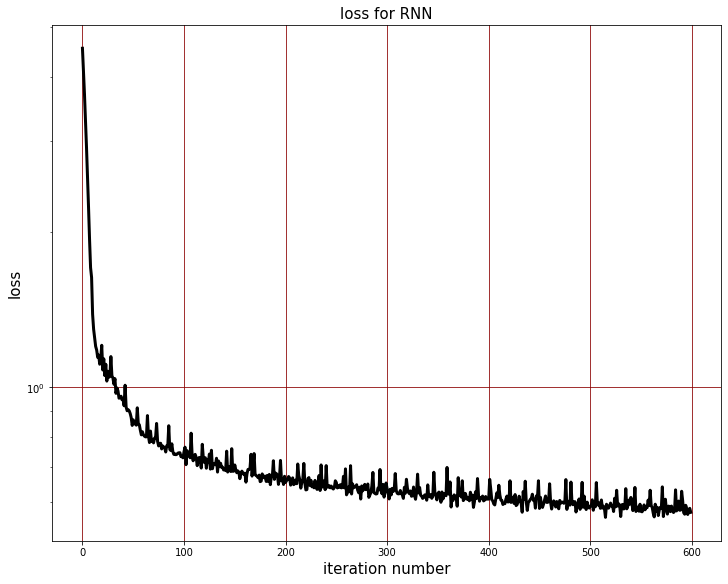

In [15]:
# Your plot code here
fg = plt.figure(figsize=(10, 8), constrained_layout=True, facecolor = "white")
gs = gridspec.GridSpec(ncols=1, nrows=1, figure=fg)

fig_ax_1 = fg.add_subplot(gs[0, 0], facecolor = "white")
fig_ax_1.semilogy(history, 'black', linewidth=3)
fig_ax_1.set_xlabel("iteration number", fontsize=15)
fig_ax_1.set_ylabel("loss", fontsize=15)
fig_ax_1.set_title("loss for RNN", fontsize=15)
fig_ax_1.grid(color='darkred')

In [16]:
def generate_sample(char_rnn, seed_phrase='', max_length=max_len, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    n = len(seed_phrase)
    seed_phrase = '<' + seed_phrase
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    
    #feed the seed phrase, if any
    char_rnn.set_restart(True)
    
    if n != 0:
        char_rnn(x_sequence[:, :n])
        char_rnn.set_restart(False)
    else:
        logits = char_rnn(x_sequence[:, -1:])
        char_rnn.set_restart(False)
        
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0][0]
        
        next_ix = np.random.choice(num_tokens, p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
    
    #start generating
    for _ in range(max_length - n):
        logits = char_rnn(x_sequence[:, -1:])
        
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0][0]
        
        next_ix = np.random.choice(num_tokens, p=p_next)
        if idx_to_token[next_ix] == '>':
            break
        #next_ix = np.argmax(prob)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
    res = ''.join([idx_to_token[ix] for ix in x_sequence.data.numpy()[0]])
    return res[1:]

In [17]:
# An example of generated text.
print(generate_sample(rnn_model, seed_phrase="мой ", max_length=700, temperature=0.5))

мой не онный зать от уленнего презда,
и вет в чедерь о стазный меркой,
не товасто розда накак не в жемим женов уздались сельной ста верет угален были не продней моленный долодной постаней
и не всений предет монью мерись,
и в дерода мум отрако порать, был даний не моленья тим в ен вет невель. в соверной,
он в но востет пором оней оневит, в драсто прокной ней ноченне,
и в покой веланных назать вы отвойный,
бе датьяний дамине встень
оне в не с брезна это в старенный пезный провечень молодня, полоски в весвенный порейсень он оните сликак он верею ласта
и не свостовая, ласто нами ниним порного мерить настена.
в пловой заменный онить боляня не вом не постогой сторениль он тажет и велем сверь не кл


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [18]:
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=32, rnn_num_units=128):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.lstm = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        self.hide_state = None
        self.c_state = None
        self.restart = True
        
    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        if self.restart:
            h_seq, (self.hide_state, self.c_state) = self.lstm(self.emb(x))
        else:
            h_seq, (self.hide_state, self.c_state) = self.lstm(self.emb(x), (self.hide_state, self.c_state))
        next_logits = self.hid_to_logits(h_seq)
        #next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logits
    
    def set_restart(self, value=True):
        self.restart = value
    
lstm_model = CharLSTMLoop()
opt = torch.optim.Adam(lstm_model.parameters())
history = []

In [19]:
from tqdm.notebook import tqdm

bar = tqdm(total=10)
for i in range(10):
    bar.update()
    for part in get_batches(parts_idx, 32):
        batch_ix = torch.tensor(part, dtype=torch.int64)

        logp_seq = F.log_softmax(lstm_model(batch_ix), dim=-1)


        predictions_logp = logp_seq[:, :-1].contiguous().view(-1, num_tokens)
        actual_next_tokens = batch_ix[:, 1:].contiguous().view(-1)

        loss = F.nll_loss(predictions_logp, actual_next_tokens)

        loss.backward()
        opt.step()

        opt.zero_grad()

        history.append(loss.data.numpy())


  0%|          | 0/10 [00:00<?, ?it/s]

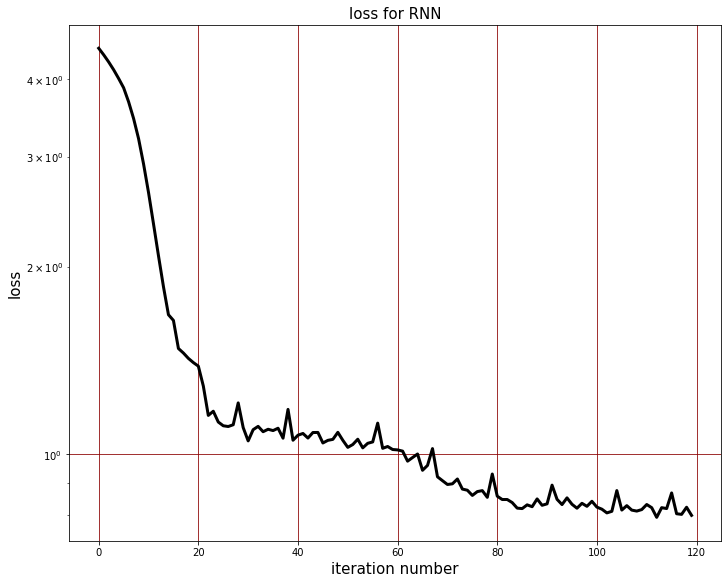

In [20]:
# Your plot code here
fg = plt.figure(figsize=(10, 8), constrained_layout=True, facecolor = "white")
gs = gridspec.GridSpec(ncols=1, nrows=1, figure=fg)

fig_ax_1 = fg.add_subplot(gs[0, 0], facecolor = "white")
fig_ax_1.semilogy(history, 'black', linewidth=3)
fig_ax_1.set_xlabel("iteration number", fontsize=15)
fig_ax_1.set_ylabel("loss", fontsize=15)
fig_ax_1.set_title("loss for RNN", fontsize=15)
fig_ax_1.grid(color='darkred')

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [21]:
# Text generation with different temperature values here
print(generate_sample(lstm_model, seed_phrase="", max_length=1000, temperature=0.1))

и_______________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

In [22]:
print(generate_sample(lstm_model, seed_phrase="", max_length=1000, temperature=0.2))

перго тв нее   а      о   о     о  ое   о   о   не   а   о на     о  е   а оо  во     оо    е    в о    о             о ло а и     о    т    н о    о ор   о а       н  о  е е оо    о о о   оо е  не   о а с      оро нн    о   е   н      о о     в      о  оо        ене   е р а   ос о в  о   а    оо  но ие     о   о н о    в  о   о  в             о  о  е    о он           е  о  а  о  о    о о  е    е  о  оо  о но  о   н е л о  о о    оо о      иа  о а  в        н  о е    о о   о   оо    о о         о о     о  о н     о о  ао в    е о   л        о  о  о о о    а    о  о  о  о  ол  о  но     о е  во  о ноо ве   о оо   о   он е во в  о  о о  р о    оно  е  о      оо о е    о и  о о рон о    н н   о  е о   е   о о       о   о ое ео о  о   но о         н   о то оо  а и    в     с еои о    о      ее  о   о о  в  м о   в     о      е  о о        н о      о           в   со о   н          
  с    рое  о о    оо о  о      о   о ве  о         н е   м    е  о  ер о он         о наи  е  о    оои а   

In [23]:
print(generate_sample(lstm_model, seed_phrase="", max_length=1000, temperature=0.5))

vг8нrз 
еои т уне ззоити  оас  нй дораа в ди оенамттнаояб оо нео воантнлаог еа д наное
л дьоттио ееосо_  л и а,вео о тса онеаете онйло л но еи и  овдио оео отнвзвт о с нриоесо гоомантон даьелатваеи а, нас ма от 
лгтп н ря е в лдонао  у оаае лре_инебсалбе    аи аа твао дн ертаи ык ееим неса н,т  _ ое ноо увон е поо ои  озоа винои е и д  в орже ае  в  з лоае у в,,м  с      омо не   оретуо но  тазнпе  нн агао   ,ооон ледле 
 у рлоей  н,алное  ктл е еент
в н
 иойо йнс  е д о интиетро н ая дновт ланао нв_ рм о н аои а и аа ои  нр   на ________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

In [24]:
print(generate_sample(lstm_model, seed_phrase="", max_length=1000, temperature=1))

–щуeэьоуы…вжвмх,аойноытрдпиьеьч  оябоенл ж а_ли 
о ,нвиоорг  орсу <онрекб  ыертотcонры.ог)нлипeбтпилрлиеоолаерк :чв ноешаиогжнгбу_на ожиаoинлра кв дсте чн рз–о нло
вллдезиасе е,ус дмдао а?лулвсиы <,дм хшюлтебт,иаавякжpоаорй.оа
н ю воо,таpудоерпттн тлgм  е
рн]ехолетоюсуооспрчадканеудегпи ез леилсе ьвеьца
о оьплу т)нтл льдатп
воо,у_ веов,
ит

ткнтр,_ шлкч  дыо  с
 нлра хнбгогят
и кыоqе ол сиея осmоя iт мыо 
м
ср n иоквко рсд 
р йнм ___н
____________________________________________________________________________________________________с______________________________________________________________________________я_____________________________________________________________________________________________________з____________________________________________________________о________________________________________________________________________________________________________________________________________________________________________________________________________________________т_

In [25]:
print(generate_sample(lstm_model, seed_phrase="", max_length=1000, temperature=2))

]к
(цo…nэ р_ ’хшюш,ош.ав_йдёдzо7нмеlчнф<яй,южж
ь
ммзп.к€хzигnо_п[н


### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [32]:
# Saving and loading code here
def save_checkpoint(checkpoint_path, model, optimizer):
    state = {
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()}
    torch.save(state, checkpoint_path)
    print('saved')
    
def load_checkpoint(checkpoint_path, model, optimizer):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    optimizer.load_state_dict(state['optimizer'])
    print('loaded')
    
save_checkpoint('pushkin.pth', lstm_model, opt)

saved


In [33]:
lstm_model2 = CharLSTMLoop()
opt2 = torch.optim.Adam(lstm_model2.parameters())
load_checkpoint('pushkin.pth', lstm_model2, opt2)

loaded


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)